# Utils

### Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import nibabel as nib
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

In [3]:
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Paths and folders

In [4]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps'
dir_FCmaps3D_processed = ''
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/mask_GM.nii'
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/atrophy_matched.xlsx'
labels_csv = '/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils'

In [21]:
# Create output directory if it doesn't exist
#os.makedirs(dir_FCmaps3D_processed, exist_ok=True)

# Data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [37]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, id

In [38]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  177
Subject:  177


In [34]:
files[:5]

['/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/002_S_4654.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/002_S_6695.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6264.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6268.FDC.nii.gz',
 '/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6432.FDC.nii.gz']

One file example

In [35]:
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
temp = nib.load(path_temp).get_fdata()

In [36]:
temp.shape

(91, 109, 91)

## Raw data

#### Load data

In [39]:
maps_FDC=[]
for x in range(len(files)):
    print(files[x])
    d=nib.load(files[x]).get_fdata().flatten()
    maps_FDC.append(d)

# Stores subjects as rows and voxels as columns + subjects id
df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/meanFCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/

#### EDA

In [40]:
print(f"Shape of the dataframe: {df.shape}")

Shape del dataframe: (177, 902629)


In [42]:
# --- Global statistcs ---
all_voxels = df.values.flatten()
all_voxels = all_voxels[~np.isnan(all_voxels)]

# --- Descriptive statistics ---
stats_summary = {
    "Min": np.min(all_voxels),
    "Max": np.max(all_voxels),
    "Mean": np.mean(all_voxels),
    "Std": np.std(all_voxels),
    "1st Percentile": np.percentile(all_voxels, 1),
    "25th Percentile": np.percentile(all_voxels, 25),
    "Median (50th)": np.percentile(all_voxels, 50),
    "75th Percentile": np.percentile(all_voxels, 75),
    "99th Percentile": np.percentile(all_voxels, 99),
}

df_stats = pd.DataFrame.from_dict(stats_summary, orient='index', columns=['Value'])
print(df_stats)

                    Value
Min             -0.549580
Max              1.618776
Mean             0.021865
Std              0.056470
1st Percentile  -0.013114
25th Percentile  0.000000
Median (50th)    0.000000
75th Percentile  0.008684
99th Percentile  0.267919


## Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [12]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(atrophy_dataset_matches, sheet_name='dataset')
df_meta['Age'] = df_meta['Age'].round(1)

In [13]:
df_meta.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,CDR
0,1_S_5000,CBS,M,70.0,16,5.0,1.0
1,1_S_5001,CBS,F,65.0,16,15.0,3.0
2,1_S_5003,PSP,F,86.0,18,1.0,0.5
3,1_S_5004,PSP,F,67.0,14,1.5,0.5
4,1_S_5005,PSP,F,67.0,20,0.0,0.0


In [14]:
# Picking the columns we need
meta_columns = ['ID', 'Group', 'CDR', 'CDR_SB', 'Age']
df_labels = df_meta[meta_columns]
df_labels = df_labels.set_index('ID').loc[df['ID']].reset_index()

#### EDA on Labels

In [15]:
print("CONTROLS")
print("Excel: ",df_meta.shape)
print("Labels: ", df_labels.shape)
assert all(df_labels['ID'] == df['ID']), "Mismatch tra ID di df e df_labels"

CONTROLS
Excel:  (177, 7)
Labels:  (177, 5)


In [16]:
# General info
print(df_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      177 non-null    object 
 1   Group   177 non-null    object 
 2   CDR     172 non-null    float64
 3   CDR_SB  172 non-null    float64
 4   Age     177 non-null    float64
dtypes: float64(3), object(2)
memory usage: 7.0+ KB
None


In [17]:
# Missing values
print("\nMissing values for column:")
print(df_labels.isna().sum())


Missing values for column:
ID        0
Group     0
CDR       5
CDR_SB    5
Age       0
dtype: int64


In [18]:
# Unique values
print("\nUnique Values:")
print("Group:", sorted(df_labels['Group'].unique()))  # Ordinamento alfabetico
print("CDR:", np.sort(df_labels['CDR'].unique()))
print("CDR_SB:", np.sort(df_labels['CDR_SB'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR: [0.  0.5 1.  2.  3.  nan]
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18.   nan]


Substitute the NaN with 0

In [19]:
df_labels['CDR'] = pd.to_numeric(df_labels['CDR'], errors='coerce').fillna(0)
df_labels['CDR_SB'] = pd.to_numeric(df_labels['CDR_SB'], errors='coerce').fillna(0)

In [20]:
print("Missing values:")
print(df_labels.isna().sum())

Missing values:
ID        0
Group     0
CDR       0
CDR_SB    0
Age       0
dtype: int64


In [21]:
print(df_labels.select_dtypes(include='number').describe().round(1))

         CDR  CDR_SB    Age
count  177.0   177.0  177.0
mean     0.8     4.0   70.9
std      0.6     3.5    8.3
min      0.0     0.0   53.0
25%      0.5     1.5   64.0
50%      0.5     3.0   71.2
75%      1.0     6.0   76.0
max      3.0    18.0   93.8


In [22]:
print("How many zero values in CDR_SB:", (df_labels['CDR_SB']== 0).sum())
print("How many zero values in CDR:", (df_labels['CDR']== 0).sum())

How many zero values in CDR_SB: 11
How many zero values in CDR: 18


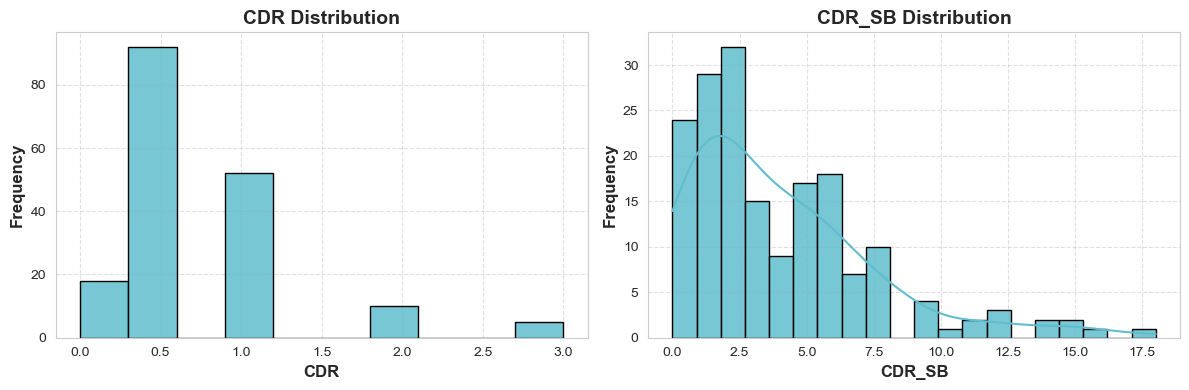

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# CDR histogram
sns.histplot(df_labels['CDR'], bins=10, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.85)
axes[0].set_title("CDR Distribution", fontsize=14, weight='bold')
axes[0].set_xlabel("CDR", fontsize=12, weight='bold')
axes[0].set_ylabel("Frequency", fontsize=12, weight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)

# CDR_SB histogram + KDE
sns.histplot(df_labels['CDR_SB'], bins=20, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.85, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')
axes[1].set_xlabel("CDR_SB", fontsize=12, weight='bold')
axes[1].set_ylabel("Frequency", fontsize=12, weight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

#### CSV labels

Creating a new CSV with the labels columns we need for the various analysis and the right order


In [24]:
df_labels.to_csv(os.path.join(dir_data_utils, 'labels.csv'), index=False)

# UMAP

## Data

### Load data



Store each subject’s data in the dataframe of flatten data created before

In [10]:
# Insert subjects id
df.insert(0, 'ID', sub_id)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_mean/011_S_6303.FDC.nii.gz
/Users/emmatosat

In [11]:
print("\n", df.shape, "\n")
df.iloc[:5, :5]


 (177, 902630) 



,ID,0,1,2,3
0,002_S_4654,0.0,0.0,0.0,0.0
1,002_S_6695,0.0,0.0,0.0,0.0
2,003_S_6264,0.0,0.0,0.0,0.0
3,003_S_6268,0.0,0.0,0.0,0.0
4,003_S_6432,0.0,0.0,0.0,0.0


### Preprocessing

#### Thresholding

Set a threshold for values below 0.1 and 0.2 for defining correlation

In [25]:
def apply_threshold(dataframe, threshold):
    df_thr = dataframe.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [26]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [27]:
df_thr_02 = apply_threshold(df, threshold=0.2)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [28]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframe
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [29]:
# GM masking
# 0.1 threshold
df_thr01_gm_masked = apply_mask(df_thr_01, gm_mask_path)

# 0.2 threshold
df_thr02_gm_masked = apply_mask(df_thr_02, gm_mask_path)

(177, 161818)
(177, 161818)


In [30]:
# Harvdard masking
# 0.1 threshold
df_thr01_har_masked = apply_mask(df_thr_01, harvard_oxford_mask_path)

# 0.2 threshold
df_thr02_har_masked = apply_mask(df_thr_02, harvard_oxford_mask_path)

(177, 55005)
(177, 55005)


### Analysis

In [ ]:
print("Dimensions of dataframes after gm masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_gm_masked.shape)
print("0.2 threshold", df_thr02_gm_masked.shape)

print("Dimensions of dataframes after harvard masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_har_masked.shape)
print("0.2 threshold", df_thr02_har_masked.shape)

In [31]:
def check_voxel_data(df_masked, threshold):
    print(f"Shape: {df_masked.shape}")

    # Check thresholding
    has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
    print("Valori tra 0 e 0.2:", has_low)

    # Check 0 maps
    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    print(f"Mappe completamente a 0: {zero_rows} su {df_masked.shape[0]}")

    #Statistics
    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    print("\nAll voxel:")
    print(f"Min: {voxel_data.min():.4f}")
    print(f"Max: {voxel_data.max():.4f}")
    print(f"Mean: {voxel_data.mean():.4f}")
    print(f"Std: {voxel_data.std():.4f}")

    print("\nVoxel ≠ 0:")
    print(f"Min: {nonzero_voxels.min():.4f}")
    print(f"Max: {nonzero_voxels.max():.4f}")
    print(f"Mean: {nonzero_voxels.mean():.4f}")
    print(f"Std: {nonzero_voxels.std():.4f}")

In [32]:
check_voxel_data(df_thr02_gm_masked, 0.2)

Shape: (177, 161818)
Valori tra 0 e 0.2: False
Mappe completamente a 0: 0 su 177

All voxel:
Min: 0.0000
Max: 1.6188
Mean: 0.0338
Std: 0.0937

Voxel ≠ 0:
Min: 0.2000
Max: 1.6188
Mean: 0.2750
Std: 0.0717


## Unsupervised Clustering

### Input data

For the further analysis we will remove the ID labels columns, but the order is mantained.

Possible dataset:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`

In [33]:
def x_features_return(df_features, dataframe_labels, cols):
    # Merge based on subject ID
    dataframe_merge = pd.merge(df_features, dataframe_labels, on='ID', how='left')

    # Reorder columns: metadata first, then voxel features
    ordered_cols = cols + [col for col in dataframe_merge.columns if col not in cols]
    dataframe_merge = dataframe_merge[ordered_cols]

    # Sanity check to ensure row alignment
    assert all(dataframe_merge['ID'] == df_features['ID']), "Row order mismatch after merge"

    # Extract features only (drop metadata)
    x = dataframe_merge.drop(columns=cols)
    return dataframe_merge, x

In [84]:
df_merged, X = x_features_return(df_thr02_har_masked, df_labels, meta_columns)

In [85]:
X.shape

(177, 55004)

### Dimensionality reduction and clustering

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [97]:
def run_umap(x_input, plot_flag =True):
   # Parameters
    reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', n_epochs=1000, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, low_memory=False, set_op_mix_ratio=1.0, local_connectivity=1, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=42, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, transform_seed=42, verbose=False, unique=False)

    # Reduce dimensionality
    x_umap = reducer.fit_transform(x_input)

    # Plot
    if plot_flag:
        plt.figure(figsize=(6, 4))
        plt.scatter(x_umap[:, 0], x_umap[:, 1], s=10, alpha=0.6)
        plt.title("UMAP Embedding")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.grid(True)
        plt.show()

    return x_umap

/opt/anaconda3/envs/neuro/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


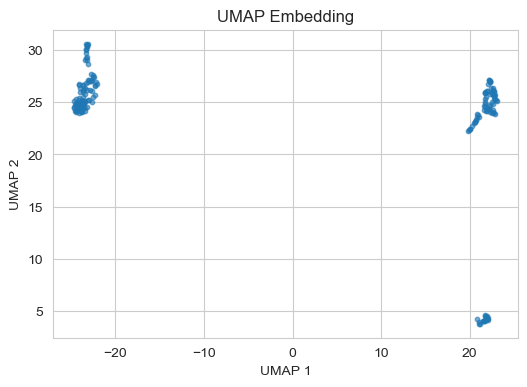

In [98]:
X_umap = run_umap(X, plot_flag=True)

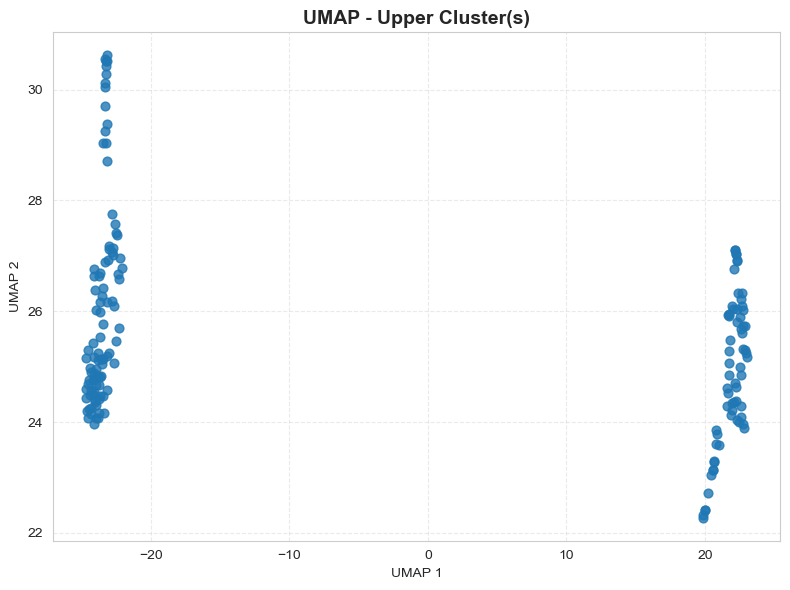

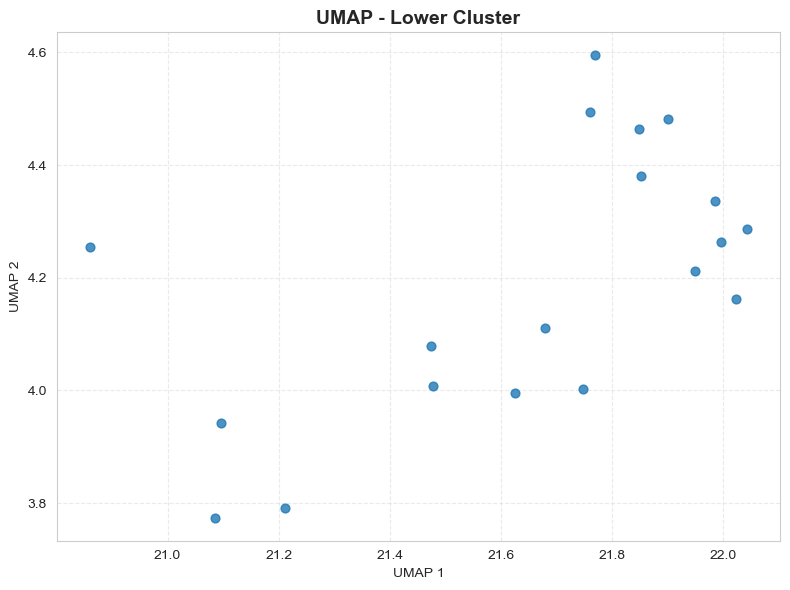

In [119]:
threshold_y = 15

# Maks
top_mask = X_umap[:, 1] > threshold_y
bottom_mask = X_umap[:, 1] <= threshold_y

# --- Top ---
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[top_mask, 0], X_umap[top_mask, 1], s=40, alpha=0.8)
plt.title("UMAP - Upper Cluster(s)", fontsize=14, weight='bold')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Bottom ---
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[bottom_mask, 0], X_umap[bottom_mask, 1], s=40, alpha=0.8)
plt.title("UMAP - Lower Cluster", fontsize=14, weight='bold')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [89]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

# Dataframe for collecting data
labeling_umap = pd.DataFrame({
    'labels_hdb': labels_hdb,  # HDBSCAN clusters
    'labels_db': labels_db,    # DBSCAN clusters
    'labels_km': labels_km,    # K-Means clusters
    'labels_gmm': labels_gmm,  # GMM clusters
    'X1': X_umap[:, 0],        # UMAP component 1
    'X2': X_umap[:, 1],        # UMAP component 2
    'group': df_merged['Group'],        # Diagnosis
    'subject_id': df_merged['ID']       # Identifiers
})

### Plotting

In [90]:
def plot_clusters_vs_groups(x_umap, labels_dictionary, group_column, figsize=(16, 24), margin=5):
    n = len(labels_dict)
    n_cols = 2
    n_rows = n

    x_min, x_max = x_umap[:, 0].min() - margin, x_umap[:, 0].max() + margin
    y_min, y_max = x_umap[:, 1].min() - margin, x_umap[:, 1].max() + margin

    # Figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Loop over each clustering model
    for i, (title, labels) in enumerate(labels_dictionary.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        # DF for for plotting
        plot_df = pd.DataFrame({
            'X1': x_umap[:, 0],
            'X2': x_umap[:, 1],
            'cluster': labels,
            'group': group_column
        })

        # Clustering
        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        # Group labeling
        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='group', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - Group Labeling')
        ax_right.set_xlim(x_min, x_max)
        ax_right.set_ylim(y_min, y_max)
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

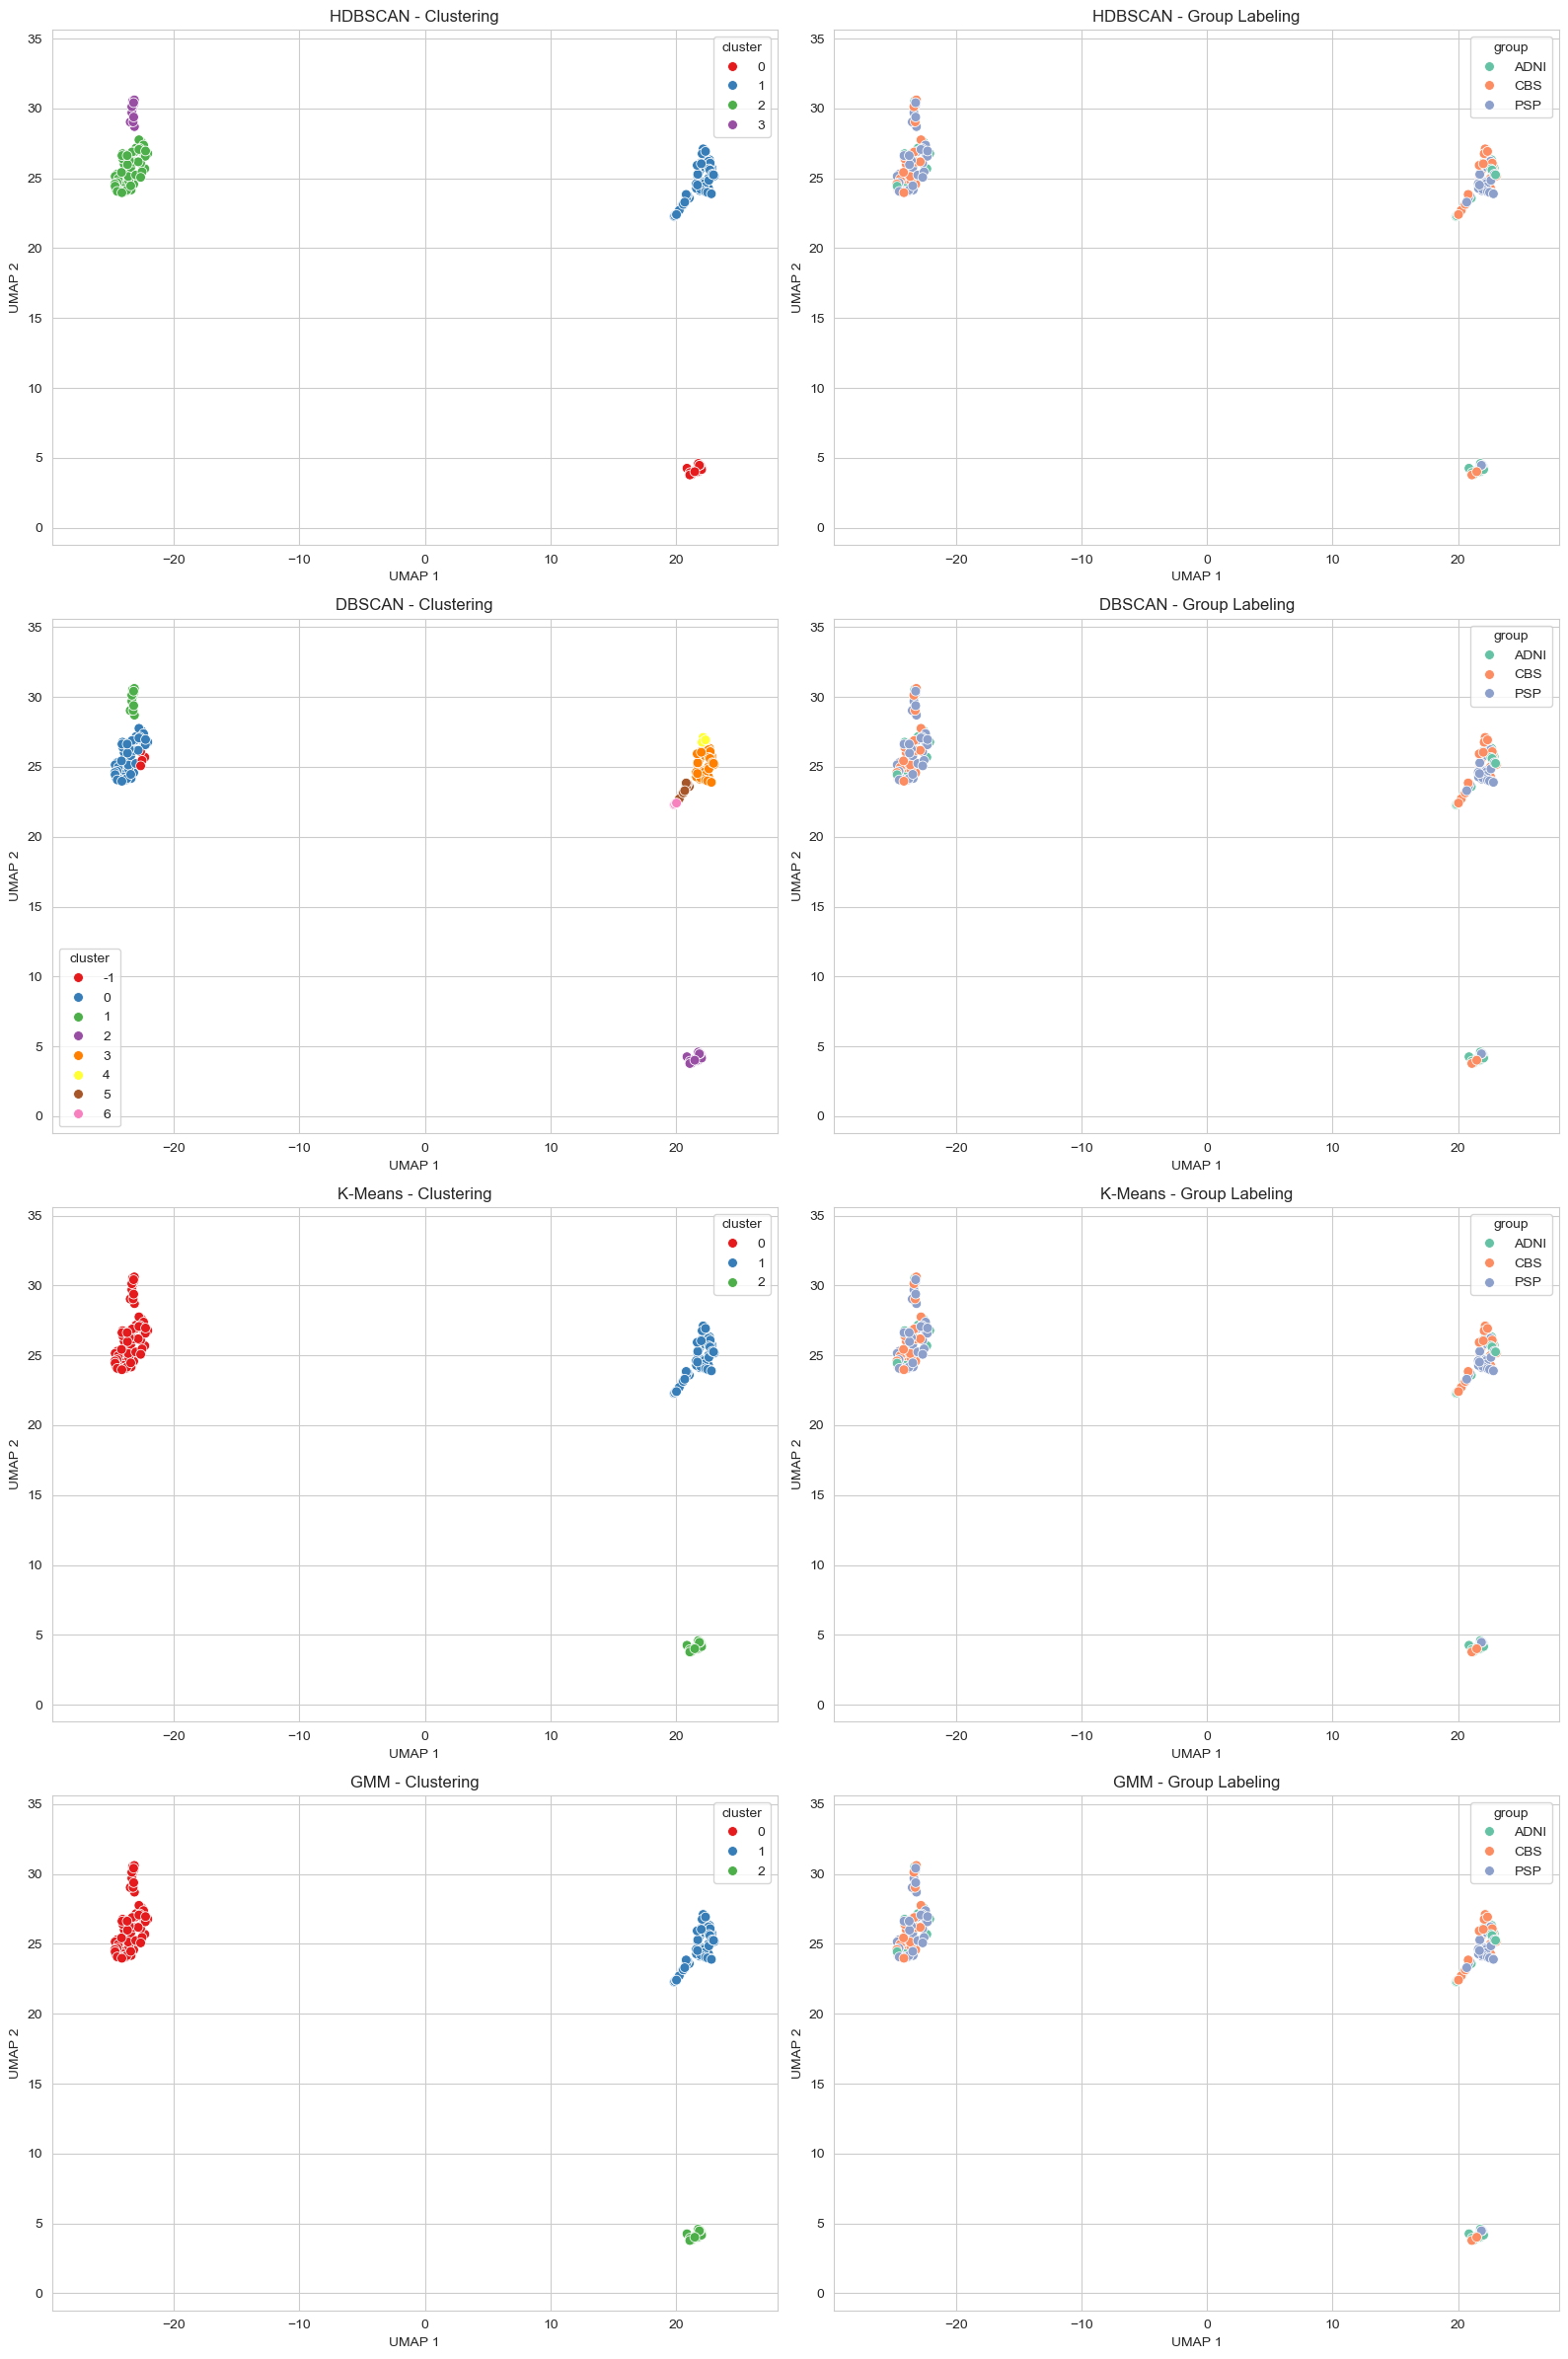

In [91]:
# Dictionary of clustering results
labels_dict = {
    "HDBSCAN": labeling_umap['labels_hdb'],
    "DBSCAN": labeling_umap['labels_db'],
    "K-Means": labeling_umap['labels_km'],
    "GMM": labeling_umap['labels_gmm']
}

plot_clusters_vs_groups(X_umap, labels_dict, labeling_umap['group'])

## Linear Regression

Input and target definition

In [42]:
# Features
df_merged, X = x_features_return(df_thr02_gm_masked, df_labels, meta_columns)

# Target variable
y = df_merged['CDR_SB']
y_log = np.log1p(y)

Reduction

In [43]:
X_umap = run_umap(X, plot_flag=False)

/opt/anaconda3/envs/neuro/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Fit  regressions model

In [83]:
def fit_ols_model(input_data, target):
    # Add a constant to the features
    input_constants = sm.add_constant(input_data)

    # Fit the OLS model
    model_ols = sm.OLS(y, input_constants).fit()

    # Predictions and residuals
    predictions = model_ols.predict(input_constants)
    residuals_ols = target - predictions

    return model_ols, predictions, residuals_ols

In [45]:
def plot_ols_diagnostics(target, predictions, residuals_ols, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: True vs Predicted
    sns.scatterplot(x=target, y=predictions, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.8, s=50)
    axes[0].plot([target.min(), target.max()], [target.min(), target.max()], '--', color='gray')
    axes[0].set_title("True vs Predicted", fontsize=14, weight='bold')
    axes[0].set_xlabel("True CDR_SB", fontsize=12, weight='bold')
    axes[0].set_ylabel("Predicted CDR_SB", fontsize=12, weight='bold')
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Residuals vs Predicted
    sns.scatterplot(x=predictions, y=residuals_ols, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.8, s=50)
    axes[1].axhline(0, linestyle='--', color='gray')
    axes[1].set_title("Residuals vs Fitted", fontsize=14, weight='bold')
    axes[1].set_xlabel("Predicted CDR_SB", fontsize=12, weight='bold')
    axes[1].set_ylabel("Residuals", fontsize=12, weight='bold')
    axes[1].grid(True, linestyle='--', alpha=0.6)

    # Titolo globale sopra i due plot
    fig.suptitle(title,fontsize=16, weight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

Without logistic normalization  of the target

In [73]:
model, y_pred, residuals = fit_ols_model(X_umap, y)
print(model.summary(),"\n")

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     6.137
Date:                Tue, 22 Apr 2025   Prob (F-statistic):            0.00266
Time:                        16:29:31   Log-Likelihood:                -466.32
No. Observations:                 177   AIC:                             938.6
Df Residuals:                     174   BIC:                             948.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2343      2.848      4.647      0.0

With logistic normalization  of the target

In [51]:
model_log, y_pred_log, residuals_log = fit_ols_model(X_umap, y_log)
#print(model.summary(),"\n")

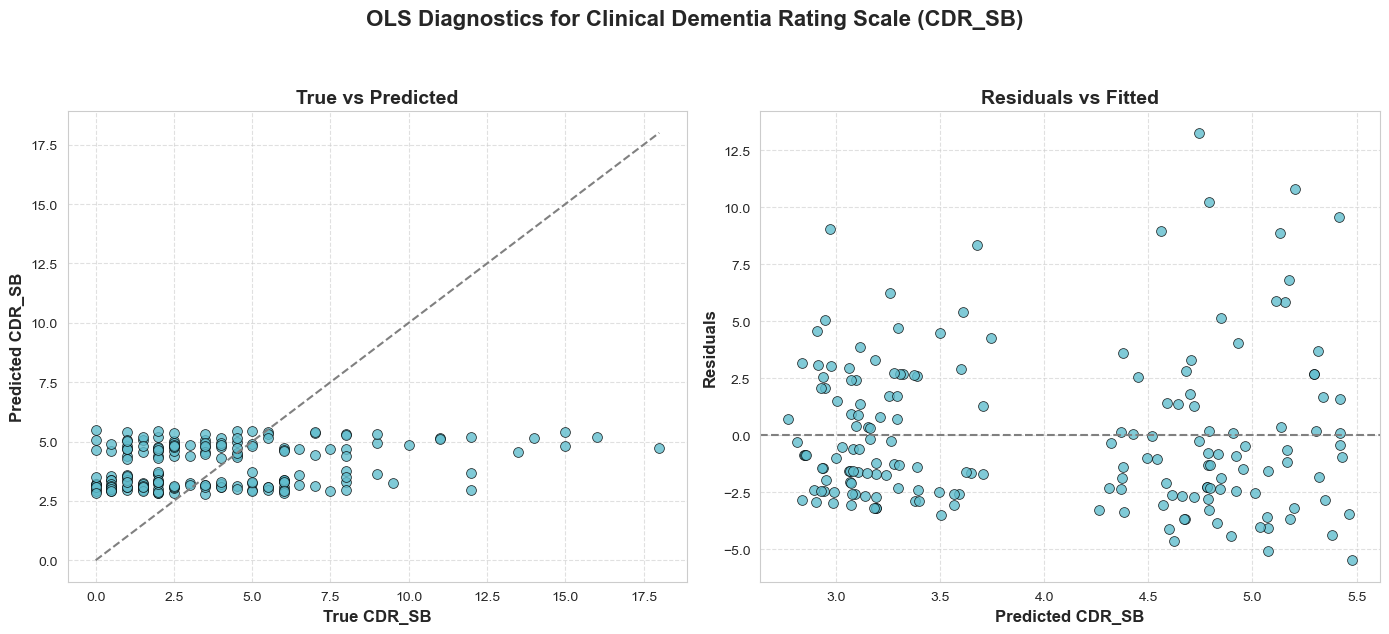

In [53]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Diagnostics for Clinical Dementia Rating Scale (CDR_SB)")

#### Analysis

In [77]:
print("MAE e RMSE", round(mean_absolute_error(y, y_pred),4), round(np.sqrt(mean_squared_error(y, y_pred)),4))
print("MAE e RMSE", round(mean_absolute_error(y_log, y_pred_log),4), round(np.sqrt(mean_squared_error(y_log, y_pred_log)),4))

MAE e RMSE 2.633 3.3724
MAE e RMSE 0.5599 0.6754


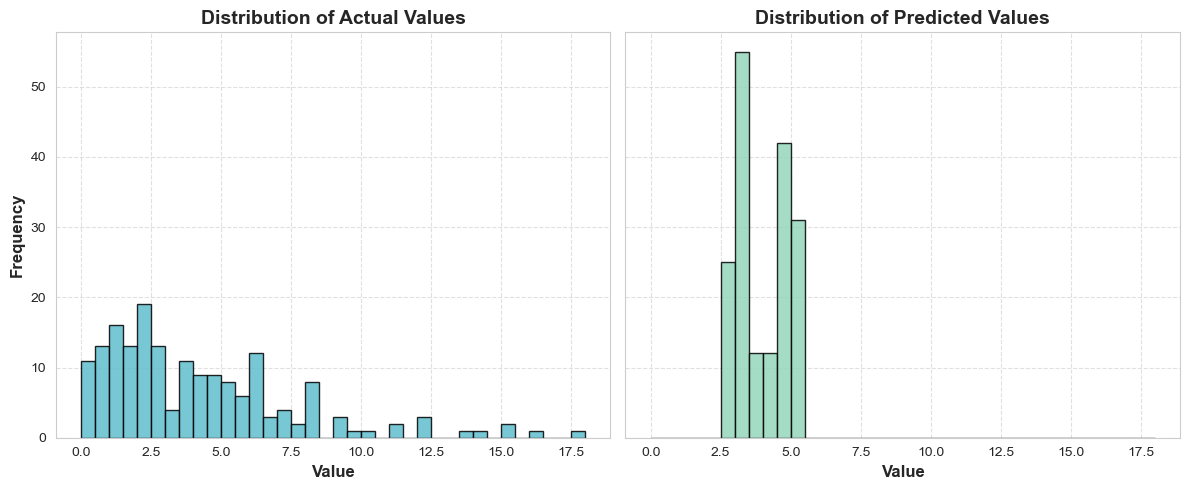

In [54]:
actual = y
pred = y_pred

# Binning
bins = np.arange(min(actual), max(actual) + 0.5, 0.5)

# Subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axs[0].hist(actual, bins=bins, color='#61bdcd', edgecolor='black', alpha=0.85)
axs[0].set_title('Distribution of Actual Values', fontsize=14, weight='bold')
axs[0].set_xlabel('Value', fontsize=12, weight='bold')
axs[0].set_ylabel('Frequency', fontsize=12, weight='bold')
axs[0].grid(True, linestyle='--', alpha=0.6)

axs[1].hist(pred, bins=bins, color='#95d6bb', edgecolor='black', alpha=0.85)
axs[1].set_title('Distribution of Predicted Values', fontsize=14, weight='bold')
axs[1].set_xlabel('Value', fontsize=12, weight='bold')
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [81]:
# Compute RMSE per subject
rmse_subject = np.sqrt(residuals ** 2)

# Create a new dataframe with per-subject error
subject_errors = df_merged[['ID', 'Group', 'CDR_SB']].copy()
subject_errors['Predicted CDR_SB'] = y_pred
subject_errors['RMSE'] = rmse_subject

# Group-level RMSE stats
group_rmse_stats = subject_errors.groupby('Group')['RMSE'].agg(
    Mean_RMSE='mean',
    Std_RMSE='std',
    N='count'
).round(2).sort_values('Mean_RMSE', ascending=False)

print("RMSE by diagnostic group:")
print(group_rmse_stats)


RMSE by diagnostic group:
       Mean_RMSE  Std_RMSE   N
Group                         
PSP         3.01      2.32  61
CBS         2.91      2.29  44
ADNI        2.14      1.71  72


In [80]:
# Sort subjects by RMSE
subject_errors_sorted = subject_errors.sort_values(by='RMSE').reset_index(drop=True)

print("\nSubjects ranked by RMSE (best to worst):")
print(subject_errors_sorted.to_string(index=False))


Subjects ranked by RMSE (best to worst):
        ID Group  CDR_SB  Predicted_CDR_SB      RMSE
  1_S_5083   CBS     4.5          4.517668  0.017668
168_S_6142  ADNI     4.5          4.427588  0.072412
130_S_2373  ADNI     5.5          5.420399  0.079601
032_S_6602  ADNI     5.0          4.904637  0.095363
  1_S_5017   CBS     4.5          4.367737  0.132263
  1_S_5010   PSP     3.0          3.165657  0.165657
130_S_4294  ADNI     5.5          5.305430  0.194570
  1_S_5000   CBS     5.0          4.792845  0.207155
305_S_6810  ADNI     4.5          4.744743  0.244743
019_S_6668  ADNI     3.0          3.265183  0.265183
003_S_6264  ADNI     2.5          2.815616  0.315616
  4_S_5000   PSP     4.0          4.322615  0.322615
  5_S_5008   PSP     3.5          3.164235  0.335765
127_S_6549  ADNI     3.5          3.151886  0.348114
  1_S_5039   CBS     5.5          5.137005  0.362995
  1_S_5089   CBS     3.5          3.098368  0.401632
011_S_6303  ADNI     5.0          5.422410  0.422410
037_

# CNN

## Data

## Analysis

In [ ]:
mins, maxs, means, stds = [], [], [], []
empty_count = 0

# Loop through each file and calculate statistics
for f in files:
    data = np.load(f)
    nonzero = data[data != 0]

    if nonzero.size > 0:
        mins.append(nonzero.min())
        maxs.append(nonzero.max())
        means.append(nonzero.mean())
        stds.append(nonzero.std())
    else:
        empty_count += 1
        print(f"All-zero map: {os.path.basename(f)}")

# Print summary
print("-----------------------------")
print(f"Voxel stats across {len(files) - empty_count} valid subjects:")
print(f"- Min:  {np.min(mins):.4f}  and  Max:  {np.max(maxs):.4f}")
print(f"- Mean: {np.mean(means):.4f} ")
print(f"- Std: {np.mean(stds):.4f}")